In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse.linalg
import scipy.linalg

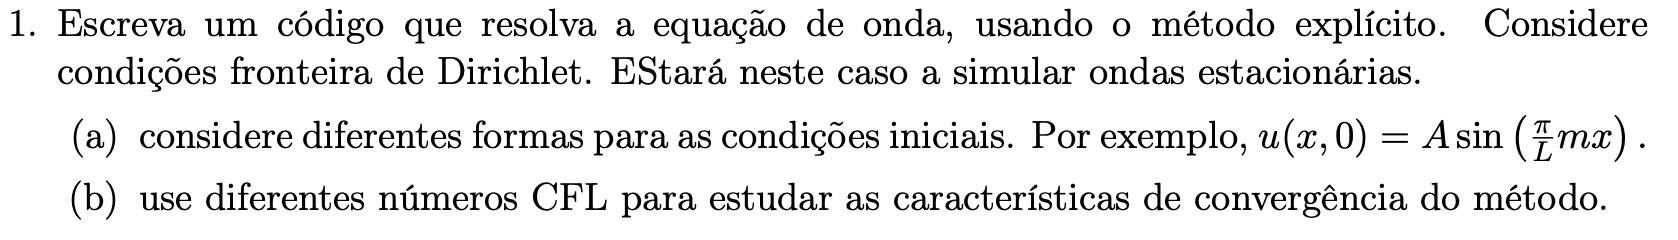

$$
u^{n+1}_i = -u^{n-1}_i + 2u^n_i + C^2
\left(u^{n}_{i+1}-2u^{n}_{i} + u^{n}_{i-1}\right),
\label{wave_pde1_step4}
\tag{3}
$$

onde definimos $C\equiv c\Delta t/ \Delta x$, e que é conhecido por número de Courant (ou de Courant-Friederichs-Lewy, CFL). Note-se que para calcular $u_i^{n+1}$, precisamos de saber $u$ em dois tempos anteriores, nomeadamente $u_i^{n}$ e $u_i^{n-1}$. Isso põe imediatamente o problema de como começar o algoritmo, pois só temos informação num tempo, $t_0=0$. Ou não? Na verdade, temos a segunda condição inicial, $u_t=0$! Para a utilizar numericamente precisamos igualmente discretizá-la. Escolhendo diferenças centrais, o que nos dá um erro de truncagem da mesma ordem dos esquemas escolhidos para as segundas derivadas, podemos escrever:

$$ u_t=0 \Rightarrow \frac{u_i^{n+1}-u_i^{n-1}}{2\Delta t} = 0 \Rightarrow u_i^{n+1}=u_i^{n-1}, \quad i=0,\ldots,N_x . \tag{4}$$

A outra condição inicial é simplesmente:

$u_i^0 = I(x_i),\;\;\;\; i=0,\ldots,N_x.$

O algoritmo pode então ser começado em $t_0=0$ alterando a fórmula geral (3) com o resultado (4):

$$
u_i^1 = u^0_i + \frac{1}{2}
C^2\left(u^{0}_{i+1}-2u^{0}_{i} + u^{0}_{i-1}\right)
\label{wave_pde1_step4_1}
\tag{5}
.$$


### Algoritmo

* calcular $u_i^0=I(x_i)$ para $i=0,\ldots,N_x$

* calcular $u^1_i$ via (5) e fazer $u^1_i=0$ para os pontos da fronteira $i=0$ e $i=N_x$,

* para cada tempo $n=1,2,\ldots,N_t-1$

    * aplicar (3)  para obter $u^{n+1}_i$ para $i=1,\ldots,N_x−1$
    
    * pôr $u^{n+1}_i=0$ para os pontos da fronteira $i=0$, $i=N_x$.



In [2]:
def initial_condition(x,*args):
    A,L,m = args
    return A * np.sin(np.pi/L * m * x)


def explicit_method(Nx,Nt,xmax,tmax,c,I,A,m):
    '''
    O esquema é estável para C<=1 
    '''
    

    x    = np.linspace(0., xmax, Nx+1)
    t    = np.linspace(0., tmax, Nt+1)
    # 
    dx   = x[1] - x[0]
    dt   = t[1] - t[0]

    #c    = 1.
    C    = c*dt/dx            # número de Courant
    if C > 1:
        print(f'C={C}\nThe method is unstable for C>1')
        return None

    C2   = C**2              # variável auxiliar
    print('Número de Courant é %.8f' %C)

    u    = np.zeros(len(x))
    u_1  = u.copy()
    u_2  = u.copy()
    
    # Impôr condição inicial u(x,0) = I(x)
    for i in range(0, Nx+1):
        u_1[i] = I(x[i],A,xmax,m) # initial_condition(x,A,L,m)
    
    plt.figure(figsize=(7,5))
    plt.plot(x,u_1,label='Initial Condition')

    # Aplicar a fórmula especial no primeiro passo, com du/dt=0 incorporada
    for i in range(1, Nx):
        u[i] = u_1[i] + 0.5*C2*(u_1[i+1] - 2*u_1[i] + u_1[i-1])
    u[0] = 0;  u[Nx] = 0   # Impôr condições fronteira Dirichlet

    # Trocar papel das variáveis antes do próximo passo (presente passa a passado, futuro passa a presente)
    u_2[:], u_1[:] = u_1, u

    for n in range(1, Nt):
        # Actualizar todos os nodos interiores no instante t[n+1]
        for i in range(1, Nx):
            u[i] = 2*u_1[i] - u_2[i] + \
                    C2*(u_1[i+1] - 2*u_1[i] + u_1[i-1])

        # Aplicar condições fronteira
        u[0] = 0;  u[Nx] = 0

        # Trocar papel das variáveis antes do próximo passo
        u_2[:], u_1[:] = u_1, u
        
    plt.plot(x,u_1,label='fim')
    
    
    plt.ylabel('Amplitude')
    plt.xlabel('X(m)')
    plt.legend()
    plt.show()
        
    return u_1

Número de Courant é 0.48888889


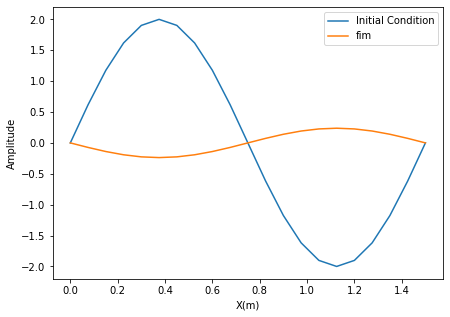

In [3]:
exp = explicit_method(20,30,1.5,1.1,1,initial_condition,2,2)

Número de Courant é 1.00000000


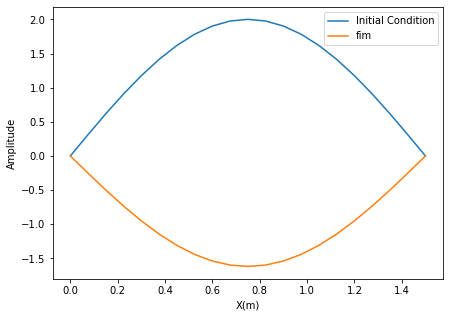

In [93]:
exp = explicit_method(20,16,1.5,1.2,1,initial_condition,2,1)

In [5]:
exp = explicit_method(20,10,1.5,1.2,1,initial_condition,2,1)

C=1.6
The method is unstable for C>1


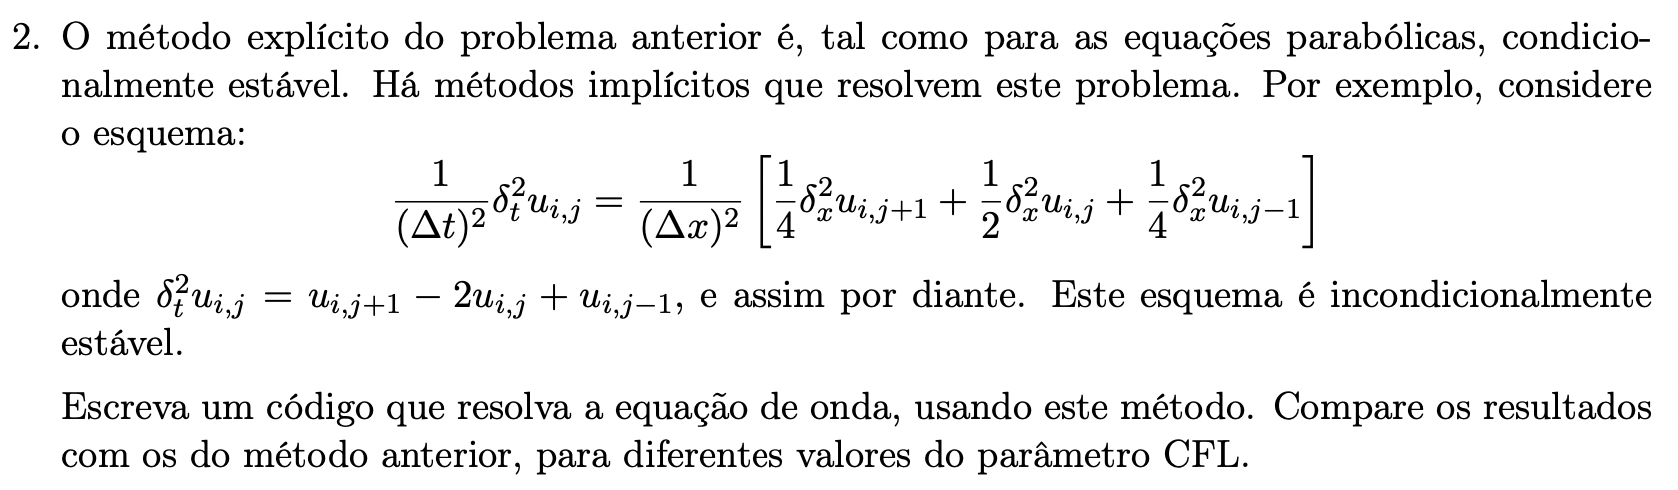

Rearranjando as equações:

$$\frac{1}{(\Delta t)^2} [u_i^{n+1}-2u_i^n+u_i^{n-1}] =\frac{1}{(\Delta x)^2} [\frac{1}{4}(u_{i+1}^{n+1}-2u_i^{n+1}+u_{i+1}^{n+1})+\frac{1}{2}(u_{i+1}^n-2u_i^n+u_{i-1}^n)+\frac{1}{4}(u_{i+1}^{n-1}-2u_i^{n-1}+u_{i-1}^{n-1})]$$

$$
.\\
.\\
.\\
$$

Rearranjando para $u_i^{n+1}$

$$u_i^{n+1}-\frac{C^2}{4}[u_{i+1}^{n+1}-2u_i^{n+1}+u_{i-1}^{n+1}]=C^2[\frac{1}{2}(u_{i+1}^n-2u_i^n+u_{i-1}^n)+\frac{1}{4}(u_{i+1}^{n-1}-2u_{i}^{n-1}+u_{i-1}^{n-1})]+2u_i^n-u_i^{n-1}$$

In [94]:
def create_ab(inf,princ,sup):
    ''' 
    Create an ab matrix (from a tridiagonal) for the scipy solve_banded method 
    '''
    ab = np.zeros((3,princ.shape[0]),dtype=complex)
    
    ab[0,1:] = inf
    ab[1,:] = princ
    ab[2,:-1] = inf
    return ab

def CN(Nx,Nt,xmax,tmax,c,cond_inicial,Aa,m):
    '''
    a: parâmetro de difusão, dtype=float
    xi: x inicial, dtype=float
    xf: x final, dtype=float
    Nx: número de pontos em x, dtype=int
    
    ---> domínio = [xi,xf] com Nx pontos
    
    Tf: Tempo final, dtype=int
    
    cond_inicial: 
         \\função para condição de fronteira, os argumentos devem estar no formato *args e os inputs serao
         input: x[i],xf,a,F
         output: float
    
    cond_fronteira:
        \\função para condição de fronteira, os argumentos devem estar no formato *args e os inputs serao
         input: xi,xf,ti 
         output: tuple, dtype=float
    '''
    # Calculo parametros
    x    = np.linspace(0., xmax, Nx+1)
    t    = np.linspace(0., tmax, Nt+1)
    # 
    dx   = x[1] - x[0]
    dt   = t[1] - t[0]

    #c    = 1.
    C    = c*dt/dx            # número de Courant
    #if C > 1:
    #    print(f'C={C}\nThe method is unstable for C>1')
    #    return None

    C2   = C**2              # variável auxiliar
    print('Número de Courant é %.8f' %C)
    
    
    u   = np.zeros(Nx+1)          # incógnita u no novo nível de tempo (u_n+1)
    u_1 = u.copy()  # No tempo atual (u_n)
    u_2 = u.copy()  # No tempo anterior (u_n-1)
    
    # Representação de uma matriz esparsa e do vector do lado direito
    A_p  = np.zeros(Nx+1)
    A_i   = np.zeros(Nx)
    A_s   = np.zeros(Nx)
    
    B_p        = np.zeros(Nx+1)
    B_i        = np.zeros(Nx)
    B_s        = np.zeros(Nx)
    
    C_p        = np.zeros(Nx+1)
    C_i        = np.zeros(Nx)
    C_s        = np.zeros(Nx)
    
    b          = np.zeros(Nx+1) # Right hand side
    
    alpha = 1+ 2/C2
    # Precálculo diagonais da matriz A
    A_p[:] = 2*alpha #1 + C2/4
    A_i[:] =  -1 #-C2/4  
    A_s[:] =  -1 #-C2/4 
    
    # Precálculo diagonais da matriz B
    B_p[:] =  2*(2/C2 -1) #2 - C2
    B_i[:] =   1 #C2/2  
    B_s[:] =   1 #C2/2
    
    # Precálculo diagonais da matriz B
    C_p[:] = -2*alpha #-(1+C2/2)
    C_i[:] =  1#C2/4  
    C_s[:] =  1#C2/4
    
    # Create the ab matrixes for the scipy solve banded method
    A = scipy.sparse.diags(
        diagonals=[A_p, A_i, A_s],
        offsets=[0, -1, 1], shape=(Nx+1, Nx+1),
        format='csr')
    
    B = scipy.sparse.diags(
        diagonals=[B_p, B_i, B_s],
        offsets=[0, -1, 1], shape=(Nx+1, Nx+1),
        format='csr')
    
    C = scipy.sparse.diags(
        diagonals=[C_p, C_i, C_s],
        offsets=[0, -1, 1], shape=(Nx+1, Nx+1),
        format='csr')
    
    
    
    # Inserir condição inicial
    #u_1[i] = I(x[i],A,xmax,m) # initial_condition(x,A,L,m)
    u_1 = cond_inicial(x,Aa,xmax,m)
        

    plt.figure(figsize=(7,5))
    plt.plot(x,u_1,label='Initial Condition')
    
    # Sistema de equações no primeiro passo difere, com du/dt=0 incorporada    
    u[:] = scipy.sparse.linalg.spsolve(A,(B.toarray()/2).dot(u_1))
    #B.toarray().dot(u_1)
    
    #u[:] = scipy.linalg.solve(A,C.toarray().dot(u_2)+B.toarray().dot(u_1))
    #scipy.sparse.linalg.spsolve
    
    # Impôr condições fronteira
    u[0] = 0  
    u[Nx] = 0
    
    # Trocar papel das variáveis antes do próximo passo (presente passa a passado, futuro passa a presente)
    u_2[:], u_1[:] = u_1, u
    
    #t = 0
    #while t < Tf+dt: 
    for i in range(1,Nt):
        # Actualizar todos os nodos interiores no instante t[j+1]
        
        #u[:] = scipy.sparse.linalg.spsolve(A,C@u_2[:]+B@u_1[:])
        u[:] = scipy.sparse.linalg.spsolve(A,C.toarray().dot(u_2)+B.toarray().dot(u_1))

        # Aplicar condições fronteira
        u[0] = 0  
        u[Nx] = 0

        # Trocar papel das variáveis antes do próximo passo
        u_2[:], u_1[:] = u_1, u
        
    plt.plot(x,u,label='fim')
    
    
    plt.ylabel('Amplitude')
    plt.xlabel('X(m)')
    plt.legend()
    plt.show()
        
    return u

Número de Courant é 1.00000000


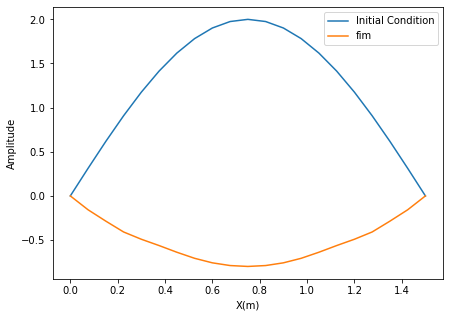

In [98]:
#Nx,Nt,xmax,tmax,c,cond_fronteira,A,m
cnn = CN(20,16,1.5,1.2,1,initial_condition,2,1) #20,16,1.5,1.2,1,initial_condition,2,1

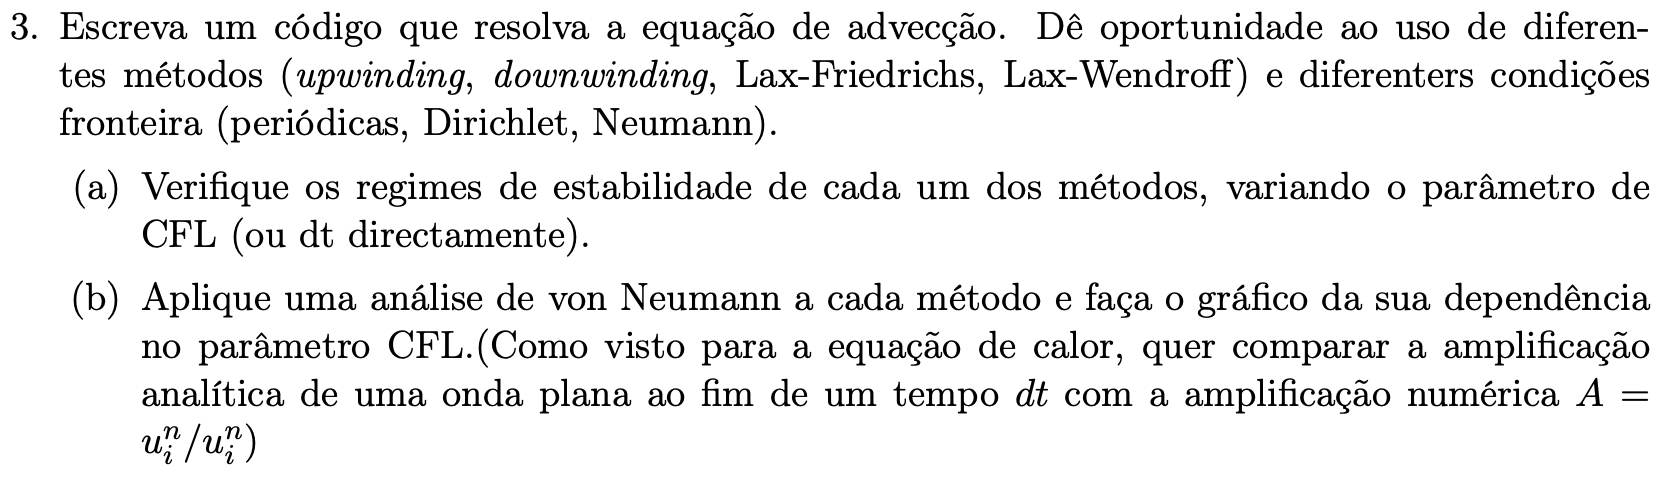